# Konnektor - Building Ligand Networks

this is Konnektor, which you can use to construct different types of Networks.

In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab
    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml
    from google.colab import output
    output.enable_custom_widget_manager()

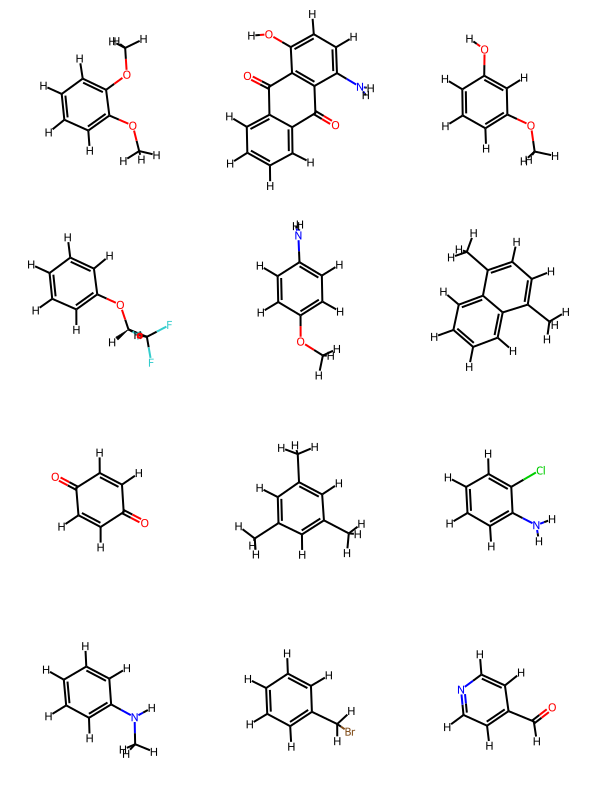

In [2]:
import sys

import numpy as np
from rdkit import Chem

try:
    from openfe_benchmarks import benzenes
    from kartograf import KartografAtomMapper, MappingRMSDScorer
except ModuleNotFoundError:
    !{sys.executable} -m pip install --no-deps git+https://github.com/OpenFreeEnergy/openfe-benchmarks.git
    !{sys.executable} -m pip install --no-deps git+https://github.com/OpenFreeEnergy/kartograf.git

    from openfe_benchmarks import benzenes
    from kartograf import KartografAtomMapper, MappingRMSDScorer


import logging
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)

components = benzenes.get_system().ligand_components

# Exclude cycle breakers! as not feasible for Hybrid topology approaches.
not_lig = ["lig_4", "lig_7", "lig_2", "lig_3"]
components = [c for c in components if(c.name not in not_lig)]

Chem.Draw.MolsToGridImage([c.to_rdkit() for c in components])

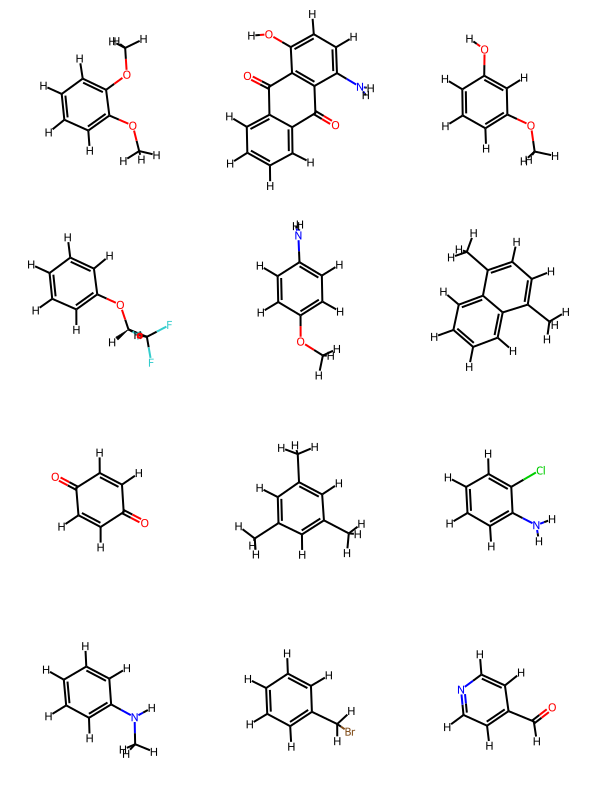

In [3]:
from konnektor.visualization.visualization import draw_ligand_network

system= benzenes.get_system()
compounds = system.ligand_components
compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], compounds))
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

In [4]:
mapper = KartografAtomMapper()
scorer = MappingRMSDScorer()
mappings = []
for cA in compounds:
    for cB in compounds:
        mapping = next(mapper.suggest_mappings(cA, cB))
        mappings.append(mapping)

mappings



[LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_1), componentA_to_componentB={10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}, annotations={}),
 LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_5), componentA_to_componentB={0: 19, 8: 20, 15: 5, 16: 21, 1: 0, 2: 1, 3: 7, 4: 6, 5: 4, 6: 3, 7: 2}, annotations={}),
 LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_6), componentA_to_componentB={8: 16, 10: 11, 11: 9, 12: 10, 13: 12, 14: 13, 15: 14, 16: 7, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 8}, annotations={}),
 LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_8), componentA_to_componentB={8: 18, 11: 4, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 0: 3, 1: 5, 2: 6

# Radial Network Layout

In [5]:
from konnektor.network_planners import RadialLigandNetworkPlanner
ligand_network_planner = RadialLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)

In [6]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Radial"
radial_network

<LigandNetwork-c55b593d5872bbbb7c9c480e396eb8ce>

/tmp/ipykernel_30177/360503311.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


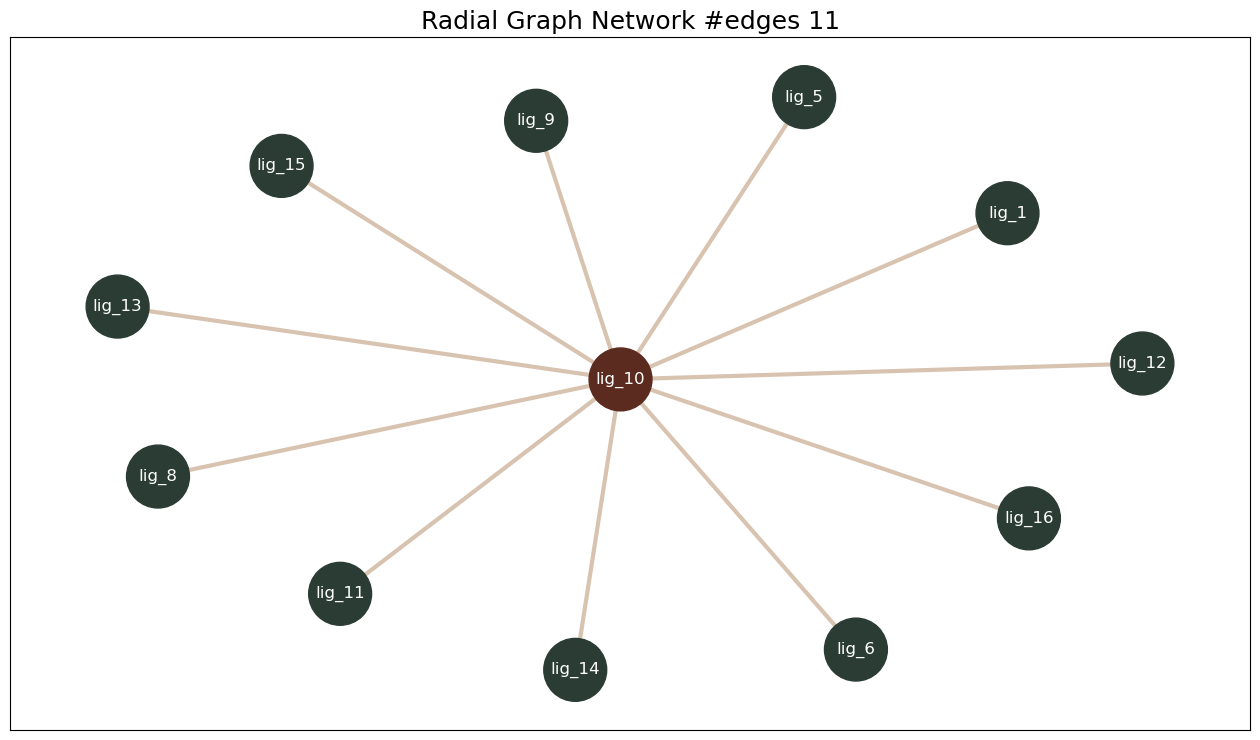

In [7]:
fig = draw_ligand_network(radial_network, title="Radial Graph");
fig.savefig(radial_network.name+"_Network.png")
fig.show()

## Starry Sky Network Layout

In [8]:
from konnektor.network_planners import StarrySkyLigandNetworkPlanner
ligand_network_planner = StarrySkyLigandNetworkPlanner(mapper=KartografAtomMapper(), 
                                                       scorer=scorer, 
                                                       target_node_connectivity=3)

In [9]:
starry_sky_network = ligand_network_planner(compounds)
starry_sky_network.name="Starry Sky"
starry_sky_network

<LigandNetwork-7c5d55cba5b1d9046b6d234bdb262aeb>

/tmp/ipykernel_30177/4158220557.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


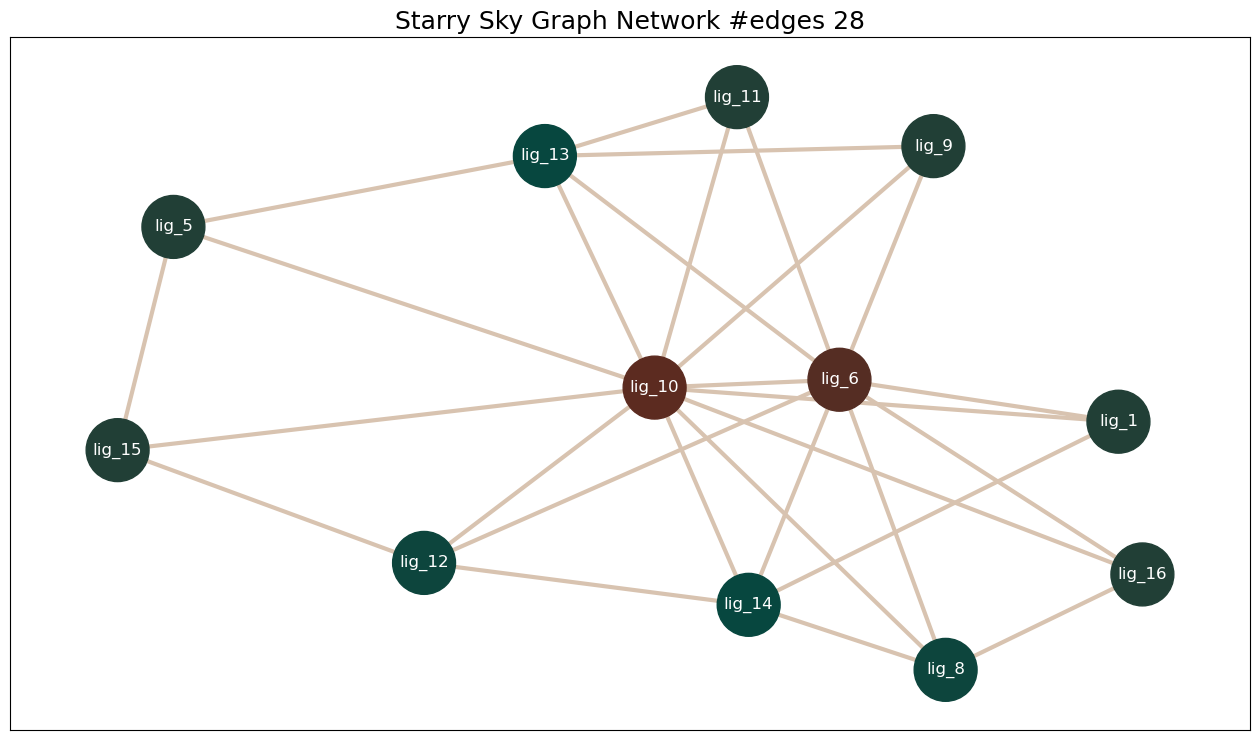

In [10]:
fig = draw_ligand_network(starry_sky_network, title="Starry Sky Graph");
fig.savefig(starry_sky_network.name+"_Network.png")
fig.show()

# Minimal Spanning Tree

In [11]:
from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)


In [12]:
mst_network = ligand_network_planner(compounds)
mst_network.name="MST"
mst_network

<LigandNetwork-43dbee22f471d9b112e07bcb16990c01>

/tmp/ipykernel_30177/2295833610.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


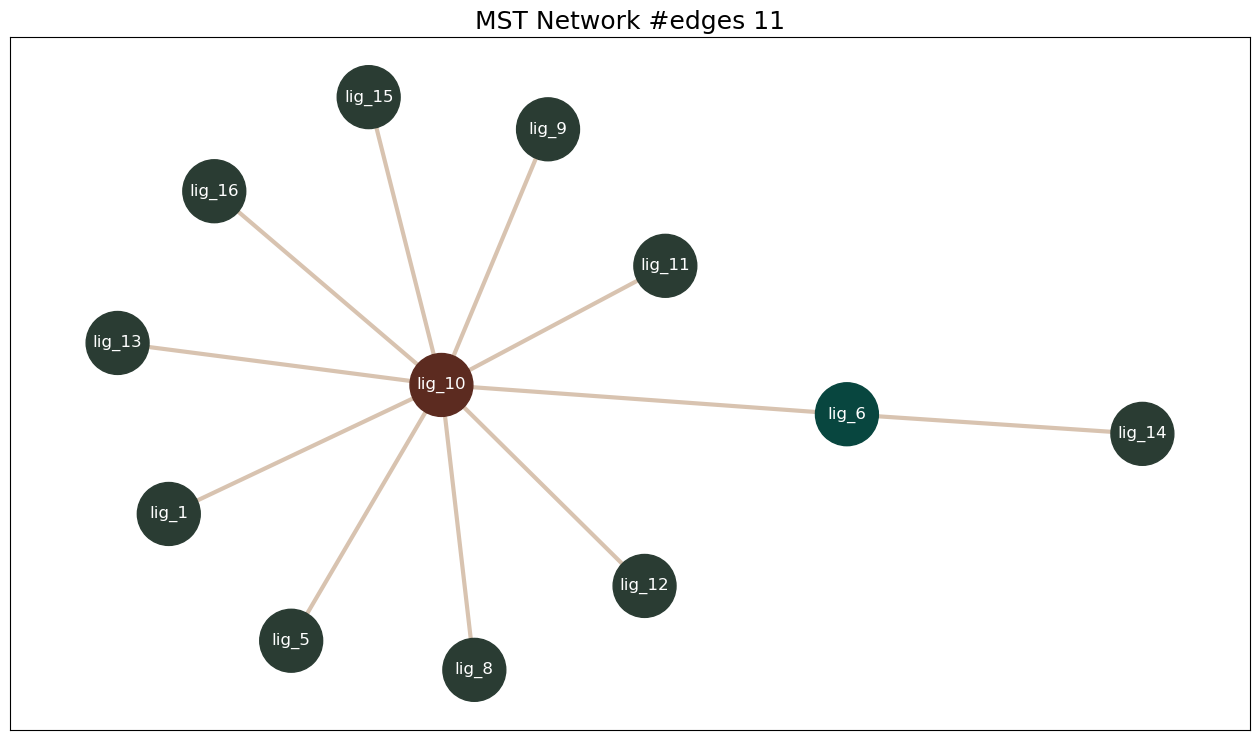

In [13]:
fig = draw_ligand_network(mst_network, "MST");
fig.savefig("MST_Network.png")
fig.show()

# Redundant MST

In [14]:
from konnektor.network_planners import RedundantMinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = (RedundantMinimalSpanningTreeLigandNetworkPlanner
                          (mapper=KartografAtomMapper(), scorer=scorer,
                           n_redundancy=3))


In [15]:
rmst_network = ligand_network_planner(compounds)
rmst_network.name="RMST"
rmst_network

Edges 66 [(0, 1), (6, 7), (0, 11), (4, 8), (9, 10), (7, 10), (0, 4), (4, 7), (6, 11), (2, 4), (2, 10), (8, 10), (4, 11), (0, 8), (0, 6), (0, 10), (2, 3), (9, 11), (1, 3), (6, 9), (7, 8), (5, 7), (3, 5), (5, 8), (1, 4), (6, 8), (2, 11), (3, 11), (0, 3), (10, 11), (3, 6), (5, 6), (0, 2), (2, 7), (0, 5), (3, 10), (8, 11), (2, 5), (1, 7), (1, 6), (2, 6), (0, 9), (3, 7), (1, 2), (8, 9), (7, 9), (5, 11), (3, 8), (4, 9), (4, 5), (5, 9), (1, 11), (2, 8), (2, 9), (0, 7), (3, 9), (7, 11), (6, 10), (1, 5), (1, 8), (1, 9), (1, 10), (5, 10), (4, 6), (3, 4), (4, 10)]
dEdges 66
nodes 12 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
sel 11 [(0, 5), (1, 5), (6, 5), (7, 5), (11, 5), (4, 5), (8, 5), (9, 2), (10, 5), (2, 5), (3, 5)]
collected 11 [(0, 5), (1, 5), (6, 5), (7, 5), (11, 5), (4, 5), (8, 5), (9, 2), (10, 5), (2, 5), (3, 5)]
Edges 55 [(0, 1), (6, 7), (0, 11), (4, 8), (9, 10), (7, 10), (0, 4), (4, 7), (6, 11), (2, 4), (2, 10), (8, 10), (4, 11), (0, 8), (0, 6), (0, 10), (2, 3), (9, 11), (1, 3), (6, 9), (

<LigandNetwork-80a337c7eab6d5677ed2f194ec227bcc>

/tmp/ipykernel_30177/1640029658.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


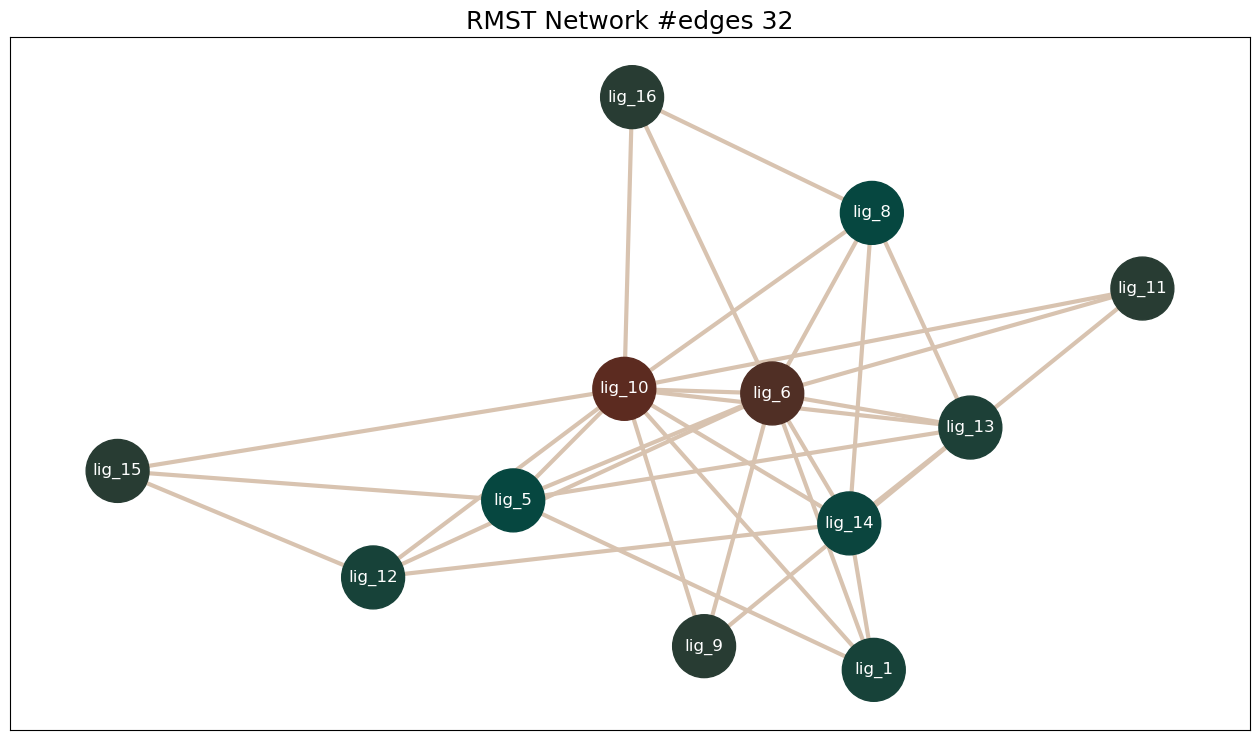

In [16]:
fig = draw_ligand_network(rmst_network, "RMST");
fig.savefig("RMST_Network.png")
fig.show()

# Cyclo Graphs

In [17]:
from konnektor.network_planners import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer,
                                                    cycle_sizes=3, node_present_in_cycles=2)

In [18]:
cyclic_network = ligand_network_planner(compounds)
cyclic_network.name="Cyclic"
cyclic_network

prepare network
calculate Network
Done


<LigandNetwork-398c54fe2e4ae16151f1d9c5acafb331>

/tmp/ipykernel_30177/1302321791.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


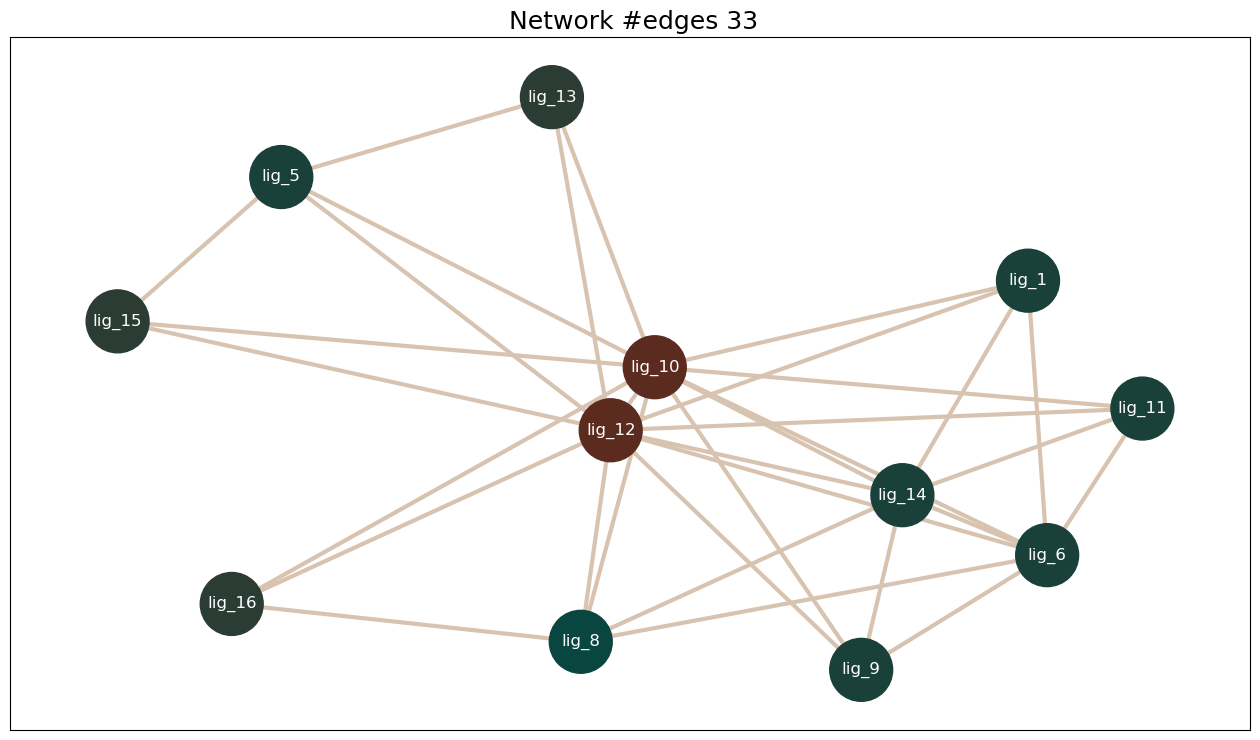

In [19]:
fig = draw_ligand_network(cyclic_network);
fig.savefig(cyclic_network.name+"_Network.png")
fig.show()

# Maximally connected network

In [20]:
import logging
from konnektor.network_planners import MaximalNetworkPlanner
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)
ligand_network_planner.nprocesses = 3


In [21]:
len(compounds)*len(compounds)//2

72

In [22]:
max_network = ligand_network_planner(compounds)
max_network.name = "Max"
max_network

<LigandNetwork-8efea407735b673d5c2bbab273e3c99a>

In [23]:
print(max_network)

<LigandNetwork-8efea407735b673d5c2bbab273e3c99a>


/tmp/ipykernel_30177/323473944.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


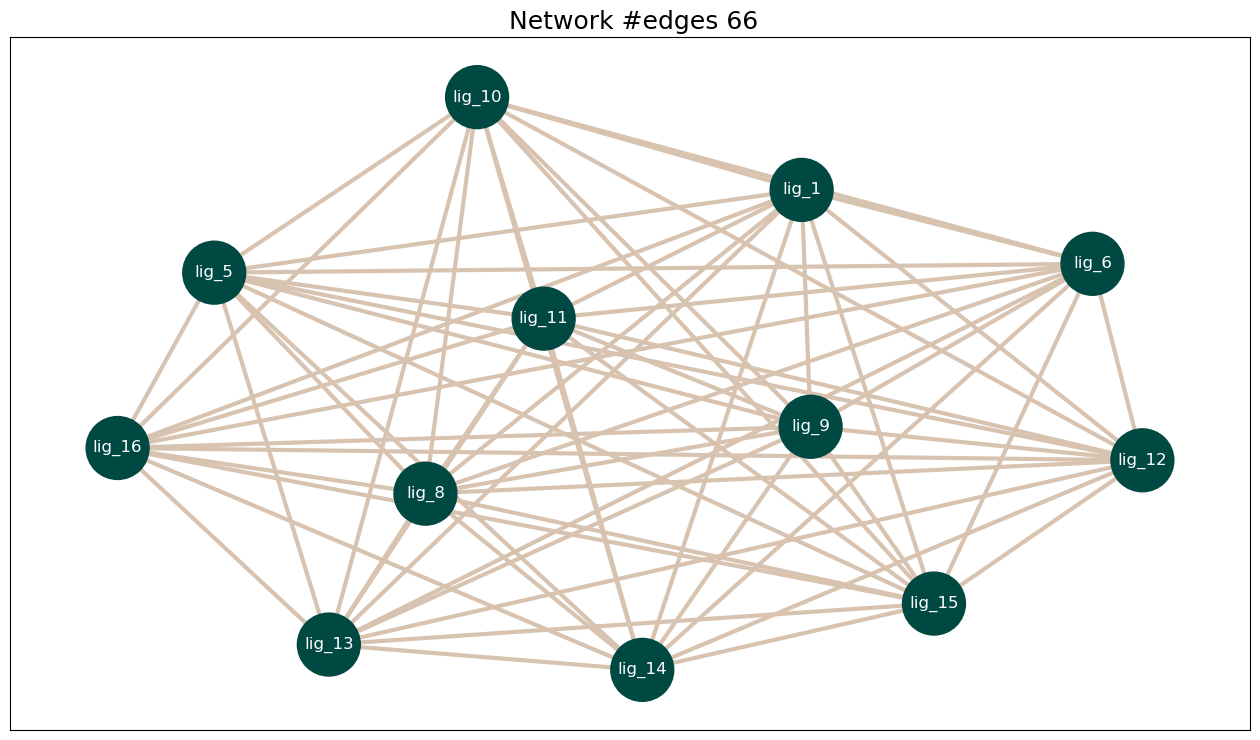

In [24]:
fig = draw_ligand_network(max_network);
fig.savefig(max_network.name+"_Network.png")
fig.show()

# Diversity Cluster Network

In [25]:
from konnektor.network_planners import DiversityNetworkPlanner
from sklearn.cluster import KMeans
ligand_network_planner = DiversityNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)

In [26]:
div_network = ligand_network_planner(compounds)
div_network.name = "Diversity Cluster"
div_network

/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


prepare network
calculate Network
Done


INFO:	Number of edges in individual networks:
 19/ [6, 13]


prepare network
calculate Network
Done


INFO:	Adding ConnectingEdges:  3
INFO:	Total Concatenating Edges:  3
INFO:	Total Concatenated Edges:  22


<LigandNetwork-42c1ea1c36930da776f951920c6a59ef>

/tmp/ipykernel_30177/3319120852.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


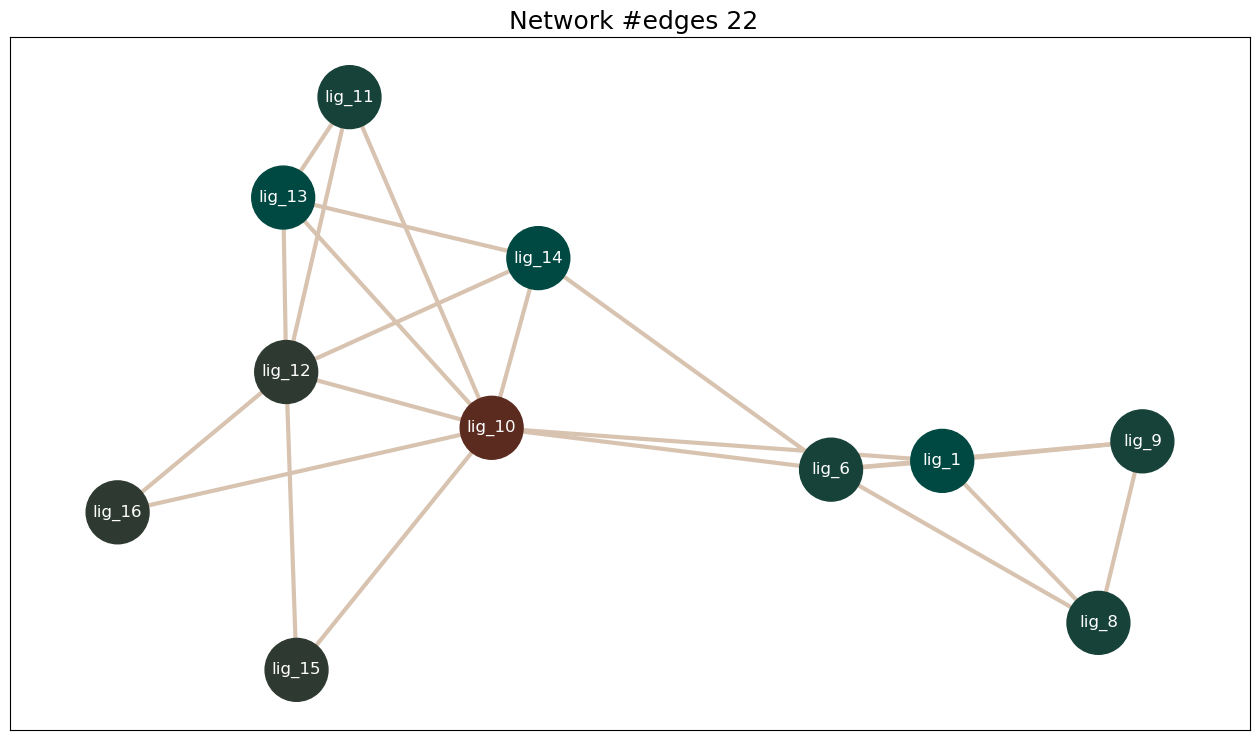

In [27]:
fig = draw_ligand_network(div_network);
fig.savefig(div_network.name+"_Network.png")
fig.show()

# Summary

(-1.0260077733376085,
 1.054179766722732,
 -0.9400586634093214,
 1.184349465753827)

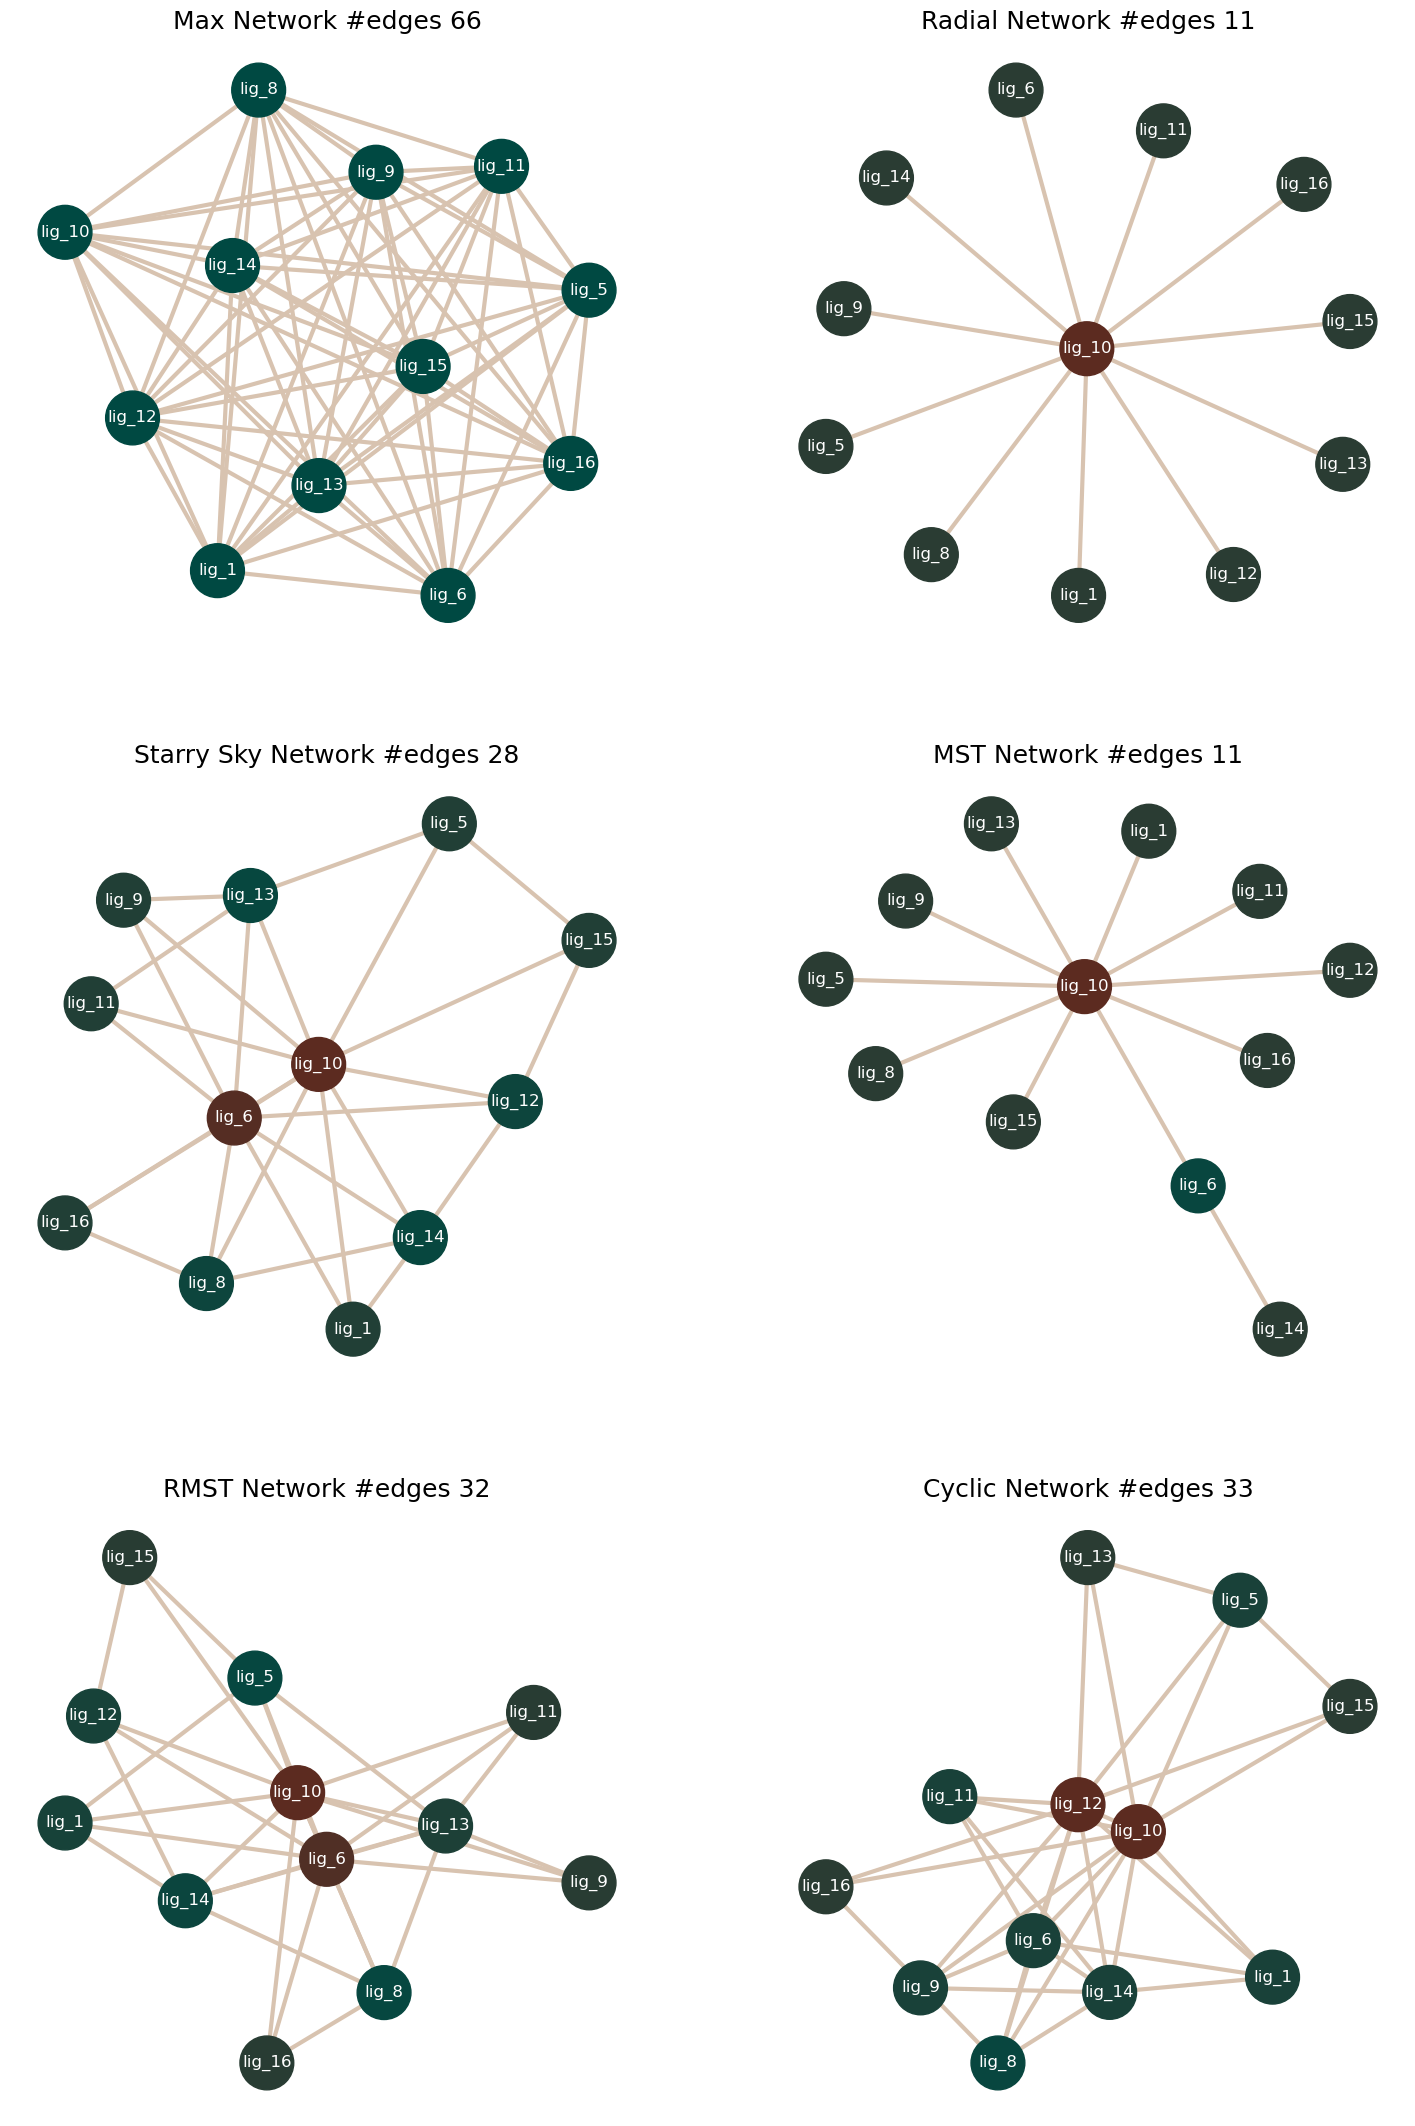

In [28]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=[9*2,3*9])
axes= np.array(axes).flat

fs = 22
for ax, net in zip(axes, [max_network, radial_network, starry_sky_network, 
                          mst_network, rmst_network,
                          cyclic_network, div_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")
axes[-1].axis("off")



In [29]:
fig.savefig("../.img/network_layouts.png", dpi=400)

## in one cell: